In [1]:
import sys
sys.path.insert(0,'/home/djl34/kl_git/scripts')
from notebook_imports import *

# client = Client()

/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
output_dir = "/home/djl34/kl_git/results"
mu_list = [2e-09, 6e-09, 2e-08, 6e-08, 2e-07]

def calculate_zscore(bin_number, selection, total_length, transformation = "log", gnocchi = False, extrainsight = False, mu_index = -1, reverse = True):

    # bin_number = 9
    # selection = 0.1    
    # total_length = 100
    
    assert total_length % 5 == 0

    first = True

    if mu_index == -1:  
        for mu in mu_list:
            filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-{selection}_mu_{mu}_bin_{bin_number}.npy")
            neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")
        
            sfs_array = np.load(filename)
            neutral_sfs = np.load(neutral_filename)[None, ...]
        
            length = total_length/5
            data_array = np.random.multinomial(length, sfs_array)[None, ...]
        
            if first:
                neutral_sfs_all = neutral_sfs
                data_array_all = data_array
                first = False
            else:
                neutral_sfs_all = np.concatenate((neutral_sfs_all, neutral_sfs), axis=0)
                data_array_all = np.concatenate((data_array_all, data_array), axis=0)
    else:
        mu = mu_list[mu_index]
        filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-{selection}_mu_{mu}_bin_{bin_number}.npy")
        neutral_filename = os.path.join(output_dir, f"SFS_output_v2.6.1_recurrent_slow/gao/multinomial_1000000/multinomial_SFS_Slinear__-0.0_mu_{mu}_bin_{bin_number}.npy")
        
        sfs_array = np.load(filename)
        neutral_sfs_all = np.load(neutral_filename)[None, ...]        
        data_array_all = np.random.multinomial(total_length, sfs_array)[None, ...]

    if gnocchi:
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        return winsfs_test.gnocchi()
    elif extrainsight:
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        return winsfs_test.extrainsight()        
    else:
        winsfs_test = mlr.WinSFS(data = data_array_all, neutral_sfs = neutral_sfs_all)
        return winsfs_test.zscore_cdf(transformation = transformation, reverse = reverse)


def calculate_power(sample_size, z_score_cutoff, bin_number, selection, window_length, transformation = "log", gnocchi = False, extrainsight = False, mu_index = -1, reverse = True):
    # if bin_number = -1, use gnocchi

    list_zscore = []
    for i in range(sample_size):
        list_zscore.append(calculate_zscore(bin_number, selection, window_length, transformation, gnocchi, extrainsight, mu_index, reverse))

    # return list_zscore
    # print(type(list_zscore))

    return sum(np.array(list_zscore) > z_score_cutoff)/sample_size, list_zscore
        

# Compare Binary

## Do over uniform mutation rate distribution

In [5]:
selection_list = [0.0, 0.1, 0.01, 0.001]
window_length_list = [100] 
mu_index_list = range(5)
mu_index_list = [-1]

list_of_list_power = []
list_of_list_zscore = []

window_length = 100
window_num = 500

for window_length in window_length_list:
    for selection in selection_list:
        print(selection)
        for mu_index in mu_index_list:
    
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "log", 
                                                 gnocchi = False, mu_index = mu_index, reverse = False)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(log(p)): 2 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(log(p)): 2 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 gnocchi = False, mu_index = mu_index, reverse = False)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 gnocchi = True, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "Gnocchi"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "Gnocchi"])

            
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 extrainsight = True, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "ExtraINSIGHT"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "ExtraINSIGHT"])
 

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length", "type"])

0.0
0.1
0.01
0.001


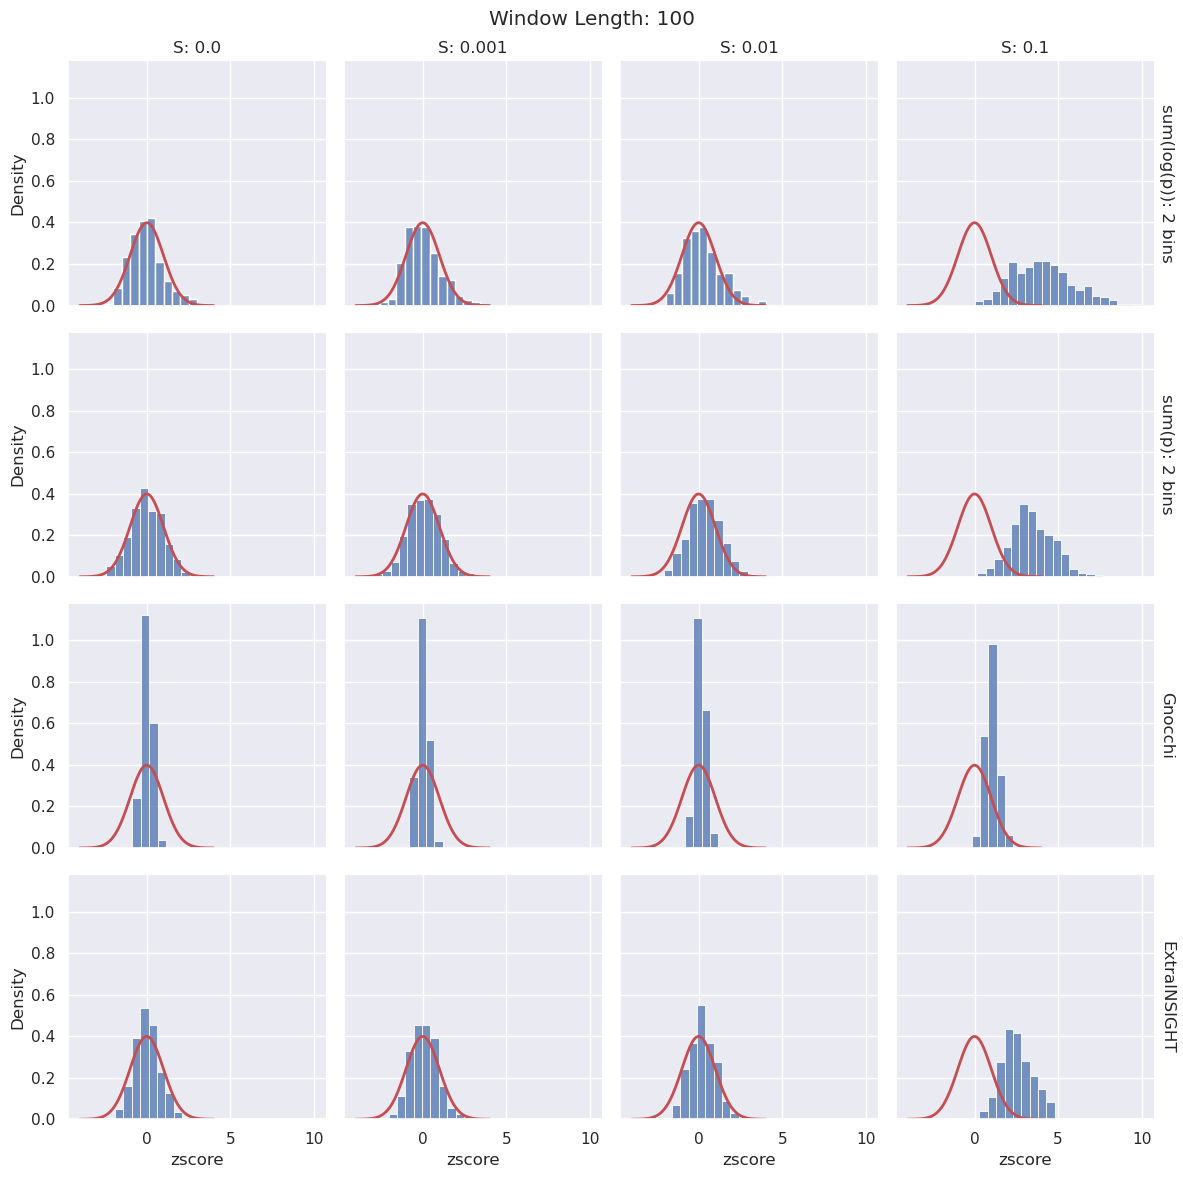

In [6]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

# plt.savefig("power_analysis_zscore_plot.svg", format="svg", bbox_inches="tight")

## Over even mutation rate distribution

### sum(log(p))

In [5]:
selection_list = [0.0, 0.1, 0.01, 0.001]

list_of_list_power = []
list_of_list_zscore = []

window_length = 100
window_num = 500

for selection in selection_list:
    print(selection)
    
    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, gnocchi = False)
    list_of_list_power.append([power, selection, "9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, gnocchi = False)
    list_of_list_power.append([power, selection, "2 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "2 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, gnocchi = True)
    list_of_list_power.append([power, selection, "gnocchi"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "gnocchi"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, gnocchi = False, extrainsight = True)
    list_of_list_power.append([power, selection, "extraInsight"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "extraInsight"])

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "type"])

0.0
0.1
0.01
0.001


/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='selection', ylabel='power'>

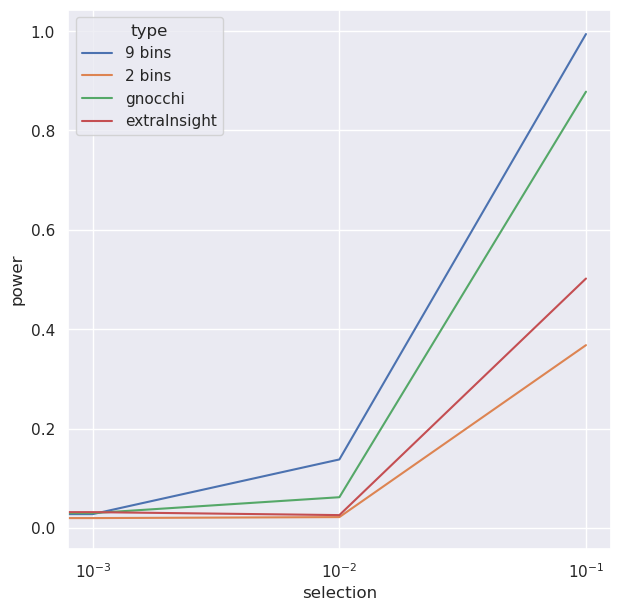

In [6]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(7, 7))

ax.set(xscale="log")

df_plot = df[df["selection"] != 0]
sns.lineplot(data=df, x="selection", y="power", hue = "type")


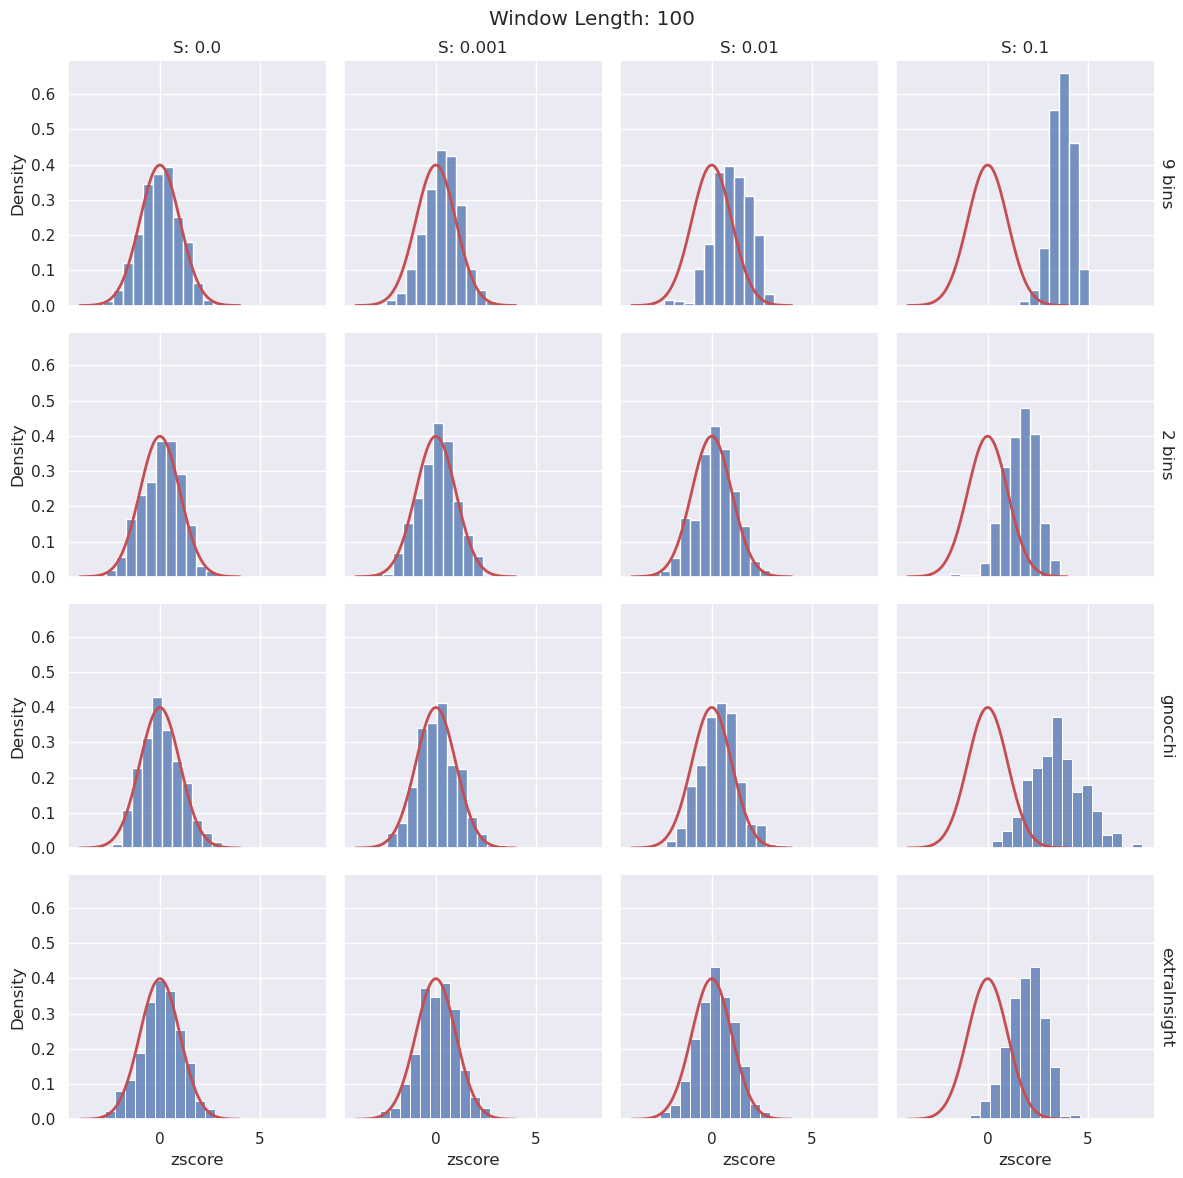

In [7]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

### sum(p)

In [56]:
selection_list = [0.0, 0.1, 0.01, 0.001]

list_of_list_power = []
list_of_list_zscore = []

window_length = 100
window_num = 500
transformation = "none"

for selection in selection_list:
    print(selection)
    
    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, transformation = "log", gnocchi = False)
    list_of_list_power.append([power, selection, "sum(log(p)): 9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(log(p)): 9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, transformation = transformation, gnocchi = False)
    list_of_list_power.append([power, selection, "sum(p): 9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(p): 9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "log", gnocchi = False)
    list_of_list_power.append([power, selection, "sum(log(p)): 2 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(log(p)): 2 bins"])

    # power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = transformation, gnocchi = False)
    # list_of_list_power.append([power, selection, "sum(p): 2 bins"])
    # for zscore in list_zscore:
    #     list_of_list_zscore.append([zscore, selection, "sum(p): 2 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = transformation, gnocchi = True)
    list_of_list_power.append([power, selection, "Gnocchi/extraInsight"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "Gnocchi/extraInsight"])

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "type"])

0.0
0.1
0.01
0.001


/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'window length = 100'}, xlabel='selection', ylabel='power'>

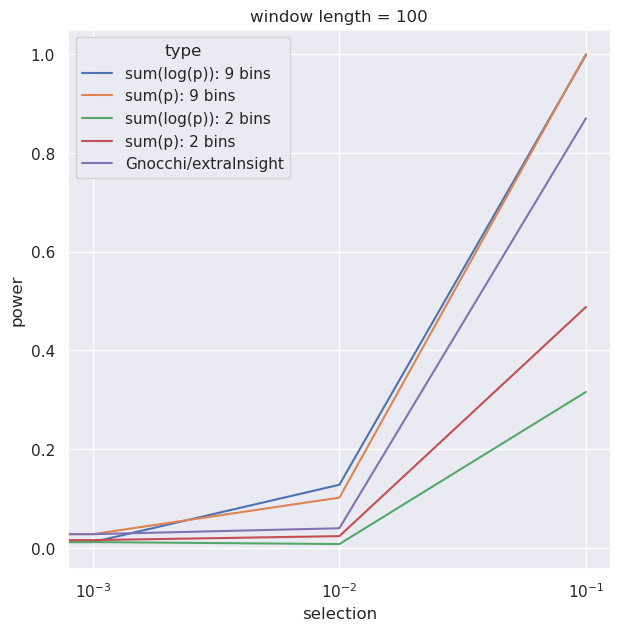

In [33]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(7, 7))
ax.set_title('window length = 100')
ax.set(xscale="log")

df_plot = df[df["selection"] != 0]
sns.lineplot(data=df, x="selection", y="power", hue = "type")


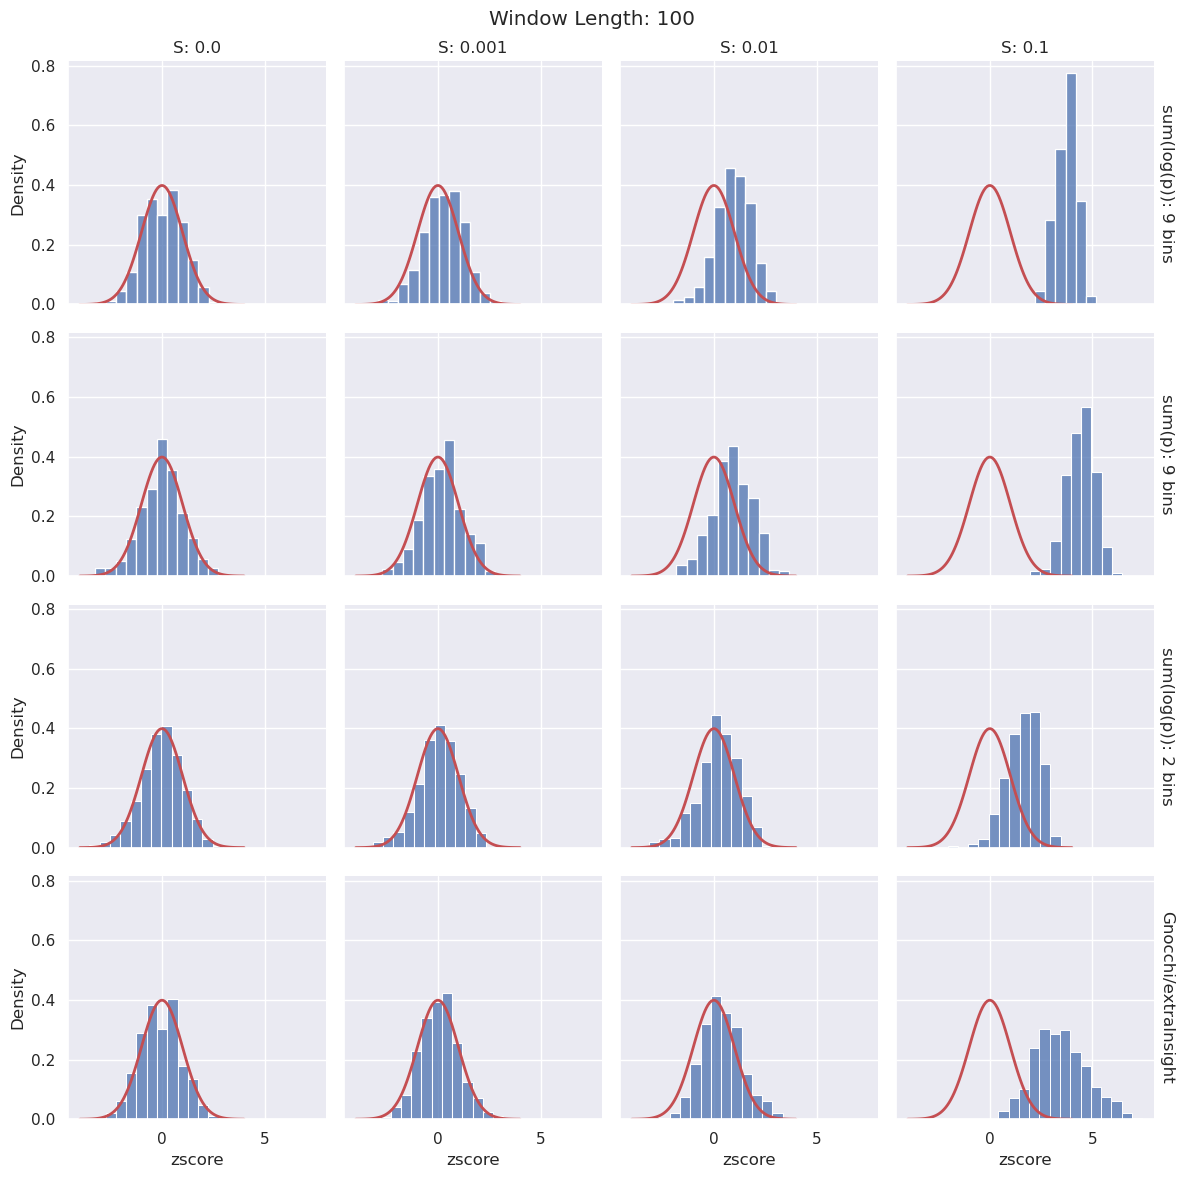

In [57]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)

plt.savefig("power_analysis_zscore_plot.svg", format="svg", bbox_inches="tight")

## Do per mutation rate

In [45]:
selection_list = [0.0, 0.1, 0.01, 0.001]
window_length_list = [100, 500, 2500] 

list_of_list_power = []
list_of_list_zscore = []

window_length = 100
window_num = 500

for window_length in window_length_list:
    for selection in selection_list:
        print(selection)
        for mu_index in range(5):
    
            power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, 
                                                 transformation = "log", gnocchi = False, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(log(p)): 9 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(log(p)): 9 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, transformation = "none", 
                                                 gnocchi = False, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(p): 9 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(p): 9 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "log", 
                                                 gnocchi = False, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(log(p)): 2 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(log(p))2 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 gnocchi = False, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "sum(p): 2 bins"])
        
            power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "none", 
                                                 gnocchi = True, mu_index = mu_index)
            list_of_list_power.append([power, selection, mu_list[mu_index], window_length, "Gnocchi/extraInsight"])
            for zscore in list_zscore:
                list_of_list_zscore.append([zscore, selection, mu_list[mu_index], window_length, "Gnocchi/extraInsight"])
 

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "mu", "window length", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "mu", "window length", "type"])

0.0
0.1
0.01
0.001
0.0
0.1
0.01
0.001
0.0
0.1
0.01
0.001


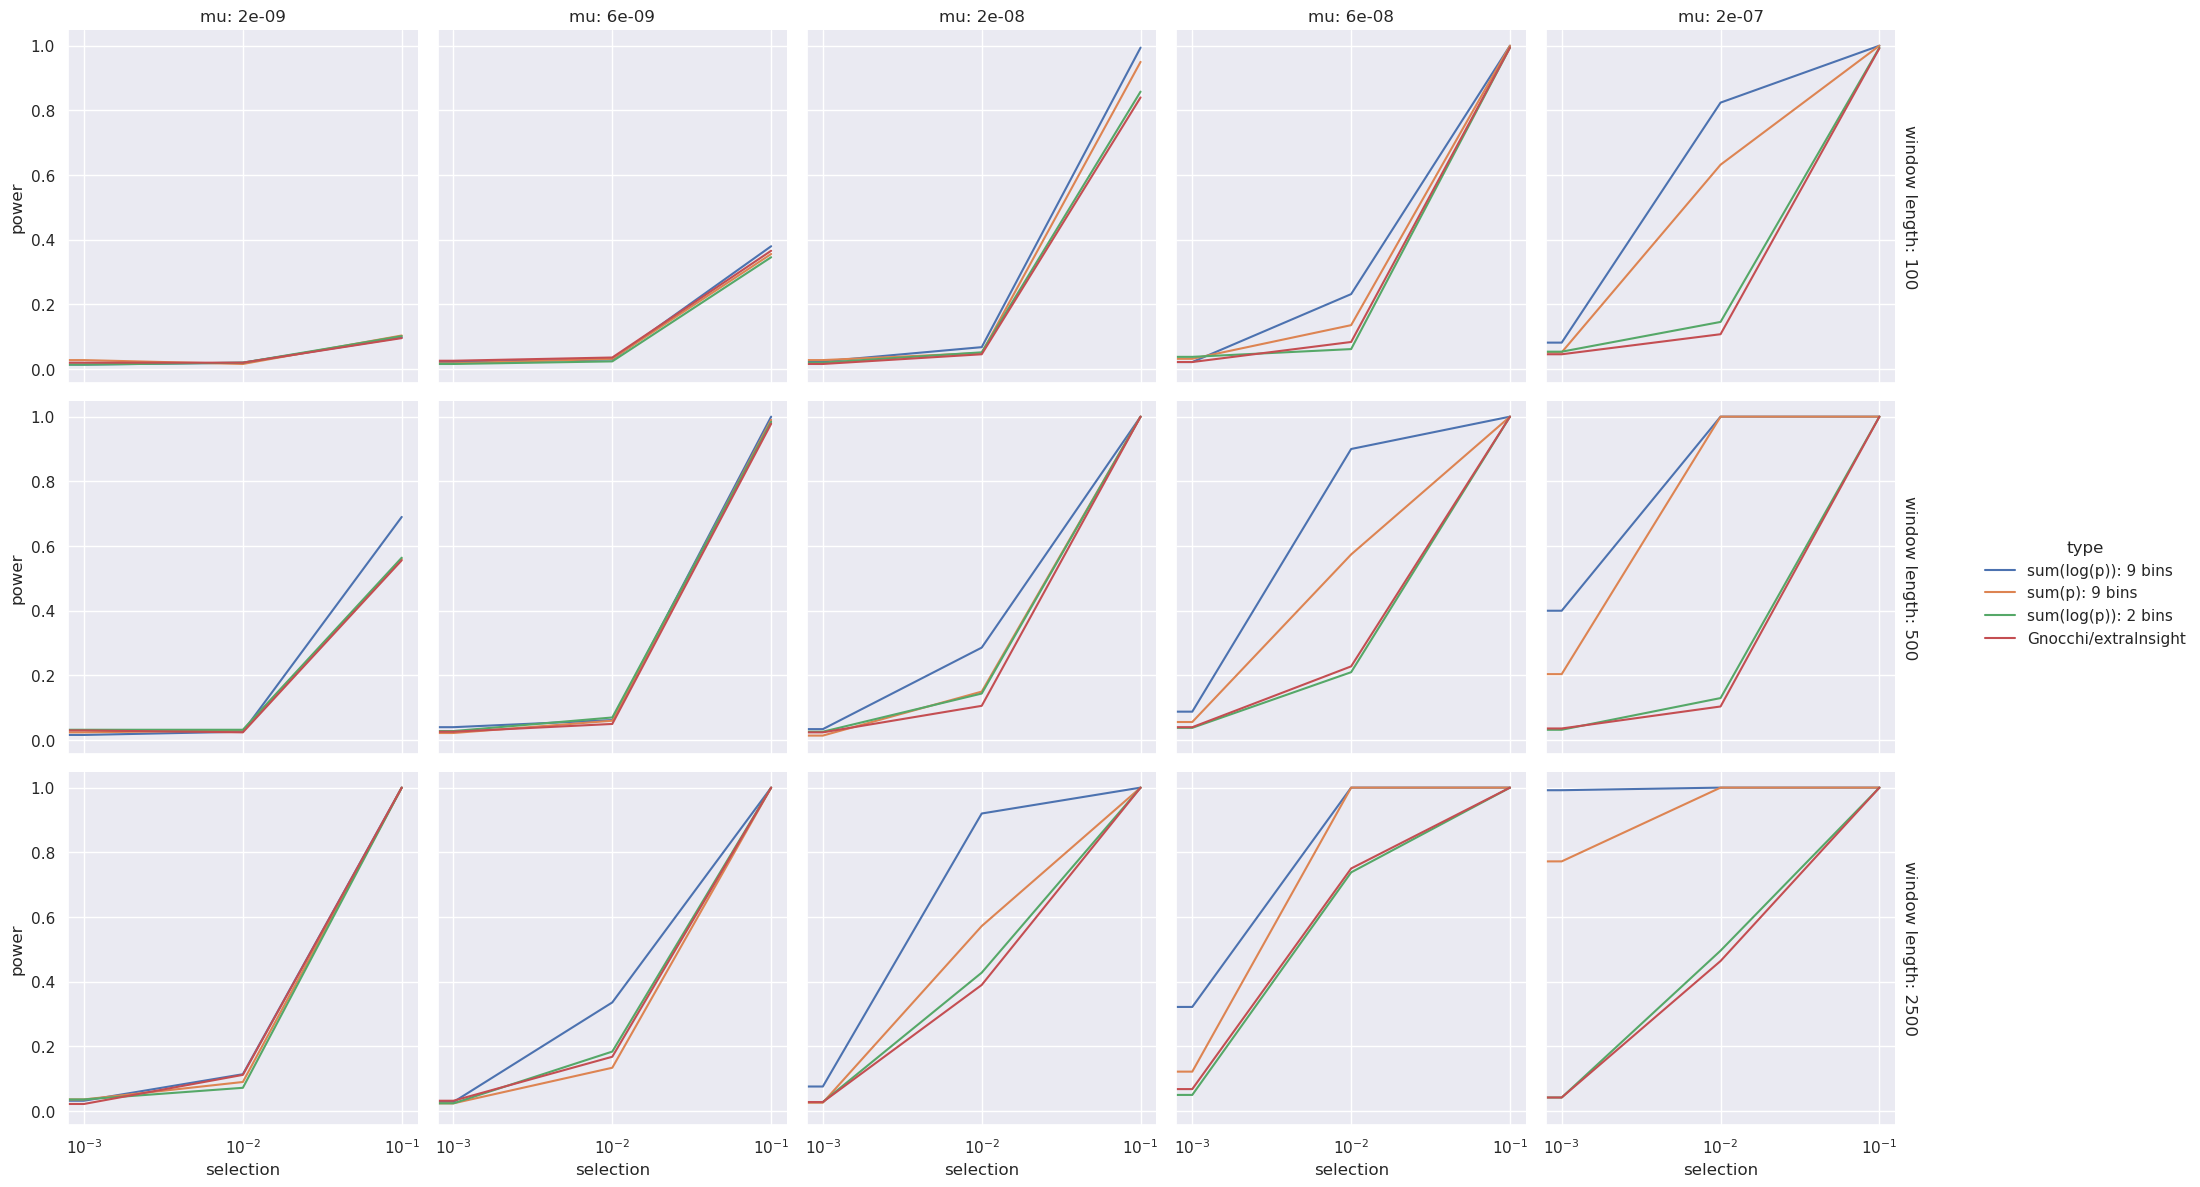

In [55]:
sns.set_theme(style="darkgrid")

type_list = ["sum(log(p)): 9 bins", "sum(p): 9 bins", "sum(log(p)): 2 bins", "Gnocchi/extraInsight"]
df_plot = df[df["type"].isin(type_list)]

# g = sns.FacetGrid(df_zscore, col="mu", row="type", height=3, margin_titles=True)
g = sns.FacetGrid(df_plot, col="mu", row="window length", height=4, margin_titles=True, hue = "type")

g.map(sns.lineplot, "selection", "power")

g.set_titles(col_template="mu: {col_name}", row_template="window length: {row_name}")
g.set(xscale="log")
g.add_legend()
# g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

# g.fig.suptitle(f'Window Length: {window_length}')
plt.savefig("power_analysis_mu_windowlength.svg", format="svg", bbox_inches="tight")

# Window Length = 1000

In [28]:
selection_list = [0.0, 0.1, 0.01, 0.001]

list_of_list_power = []
list_of_list_zscore = []

window_length = 1000
window_num = 500
transformation = "none"

for selection in selection_list:
    print(selection)
    
    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, transformation = "log", gnocchi = False)
    list_of_list_power.append([power, selection, "sum(log(p)): 9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(log(p)): 9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 9, selection, window_length = window_length, transformation = transformation, gnocchi = False)
    list_of_list_power.append([power, selection, "sum(p): 9 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(p): 9 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = "log", gnocchi = False)
    list_of_list_power.append([power, selection, "sum(log(p)): 2 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(log(p))2 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = transformation, gnocchi = False)
    list_of_list_power.append([power, selection, "sum(p): 2 bins"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "sum(p): 2 bins"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = transformation, gnocchi = True)
    list_of_list_power.append([power, selection, "gnocchi"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "gnocchi"])

    power, list_zscore = calculate_power(window_num, 2, 2, selection, window_length = window_length, transformation = transformation, gnocchi = False, extrainsight = True)
    list_of_list_power.append([power, selection, "extraInsight"])
    for zscore in list_zscore:
        list_of_list_zscore.append([zscore, selection, "extraInsight"])

df = pd.DataFrame(list_of_list_power, columns=["power", "selection", "type"])
df_zscore = pd.DataFrame(list_of_list_zscore, columns=["zscore", "selection", "type"])

0.0
0.1
0.01
0.001


/home/djl34/mambaforge/envs/raklette/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'window length: 1000'}, xlabel='selection', ylabel='power'>

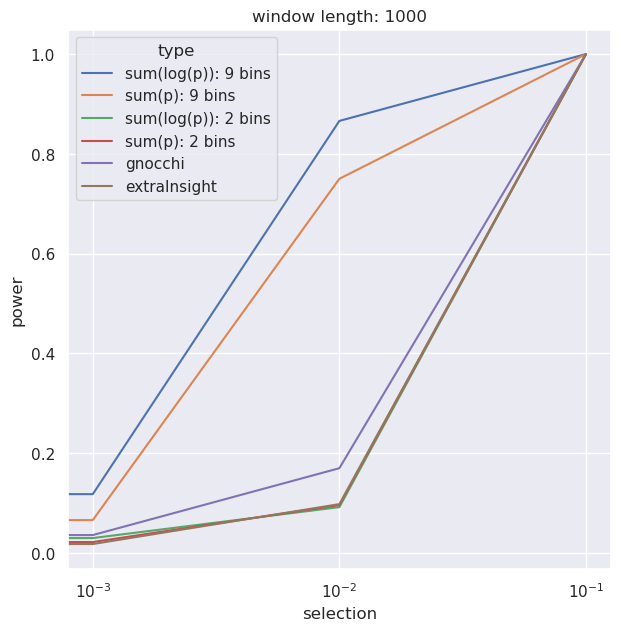

In [31]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(7, 7))
ax.set_title('window length: 1000')
ax.set(xscale="log")

df_plot = df[df["selection"] != 0]
sns.lineplot(data=df, x="selection", y="power", hue = "type")


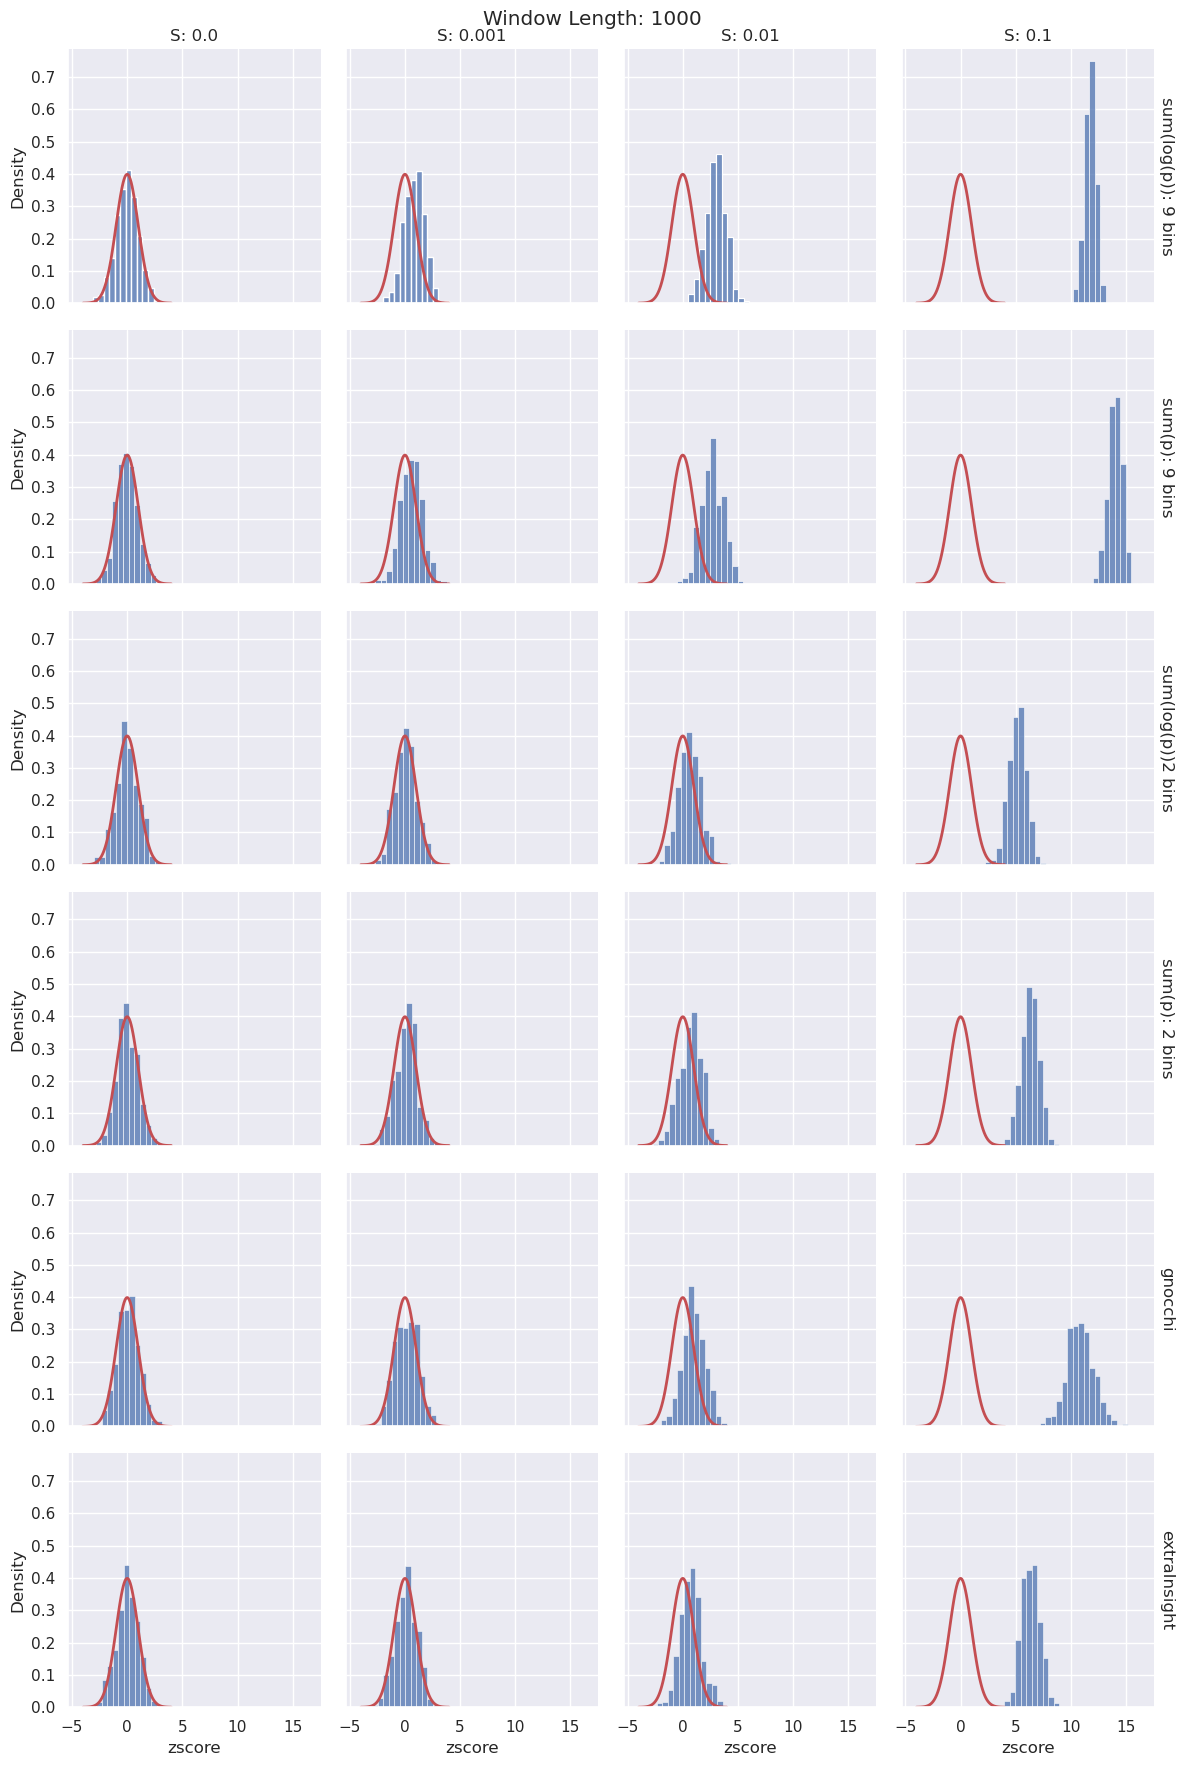

In [30]:
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(df_zscore, col="selection", row="type", height=3, margin_titles=True)

g.map(sns.histplot, "zscore", binwidth=0.5, kde=False, stat='density', label='samples')

g.set_titles(col_template="S: {col_name}", row_template="{row_name}")

g.fig.suptitle(f'Window Length: {window_length}')

def standard_normal(*args, **kwargs):
    # x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(-4, 4, 100)
    y_pdf = scipy.stats.norm.pdf(x_pdf)

    plt.plot(x_pdf, y_pdf, 'r', lw=2, label='pdf')   

g.map(standard_normal)